### 0.0. Dependencies

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### 1.1. Mobile/retail data

#### 1.1.1 Loading in

In [3]:
retail_areas = gpd.read_file("retail_areas.gpkg", layer="retail_areas")

In [4]:
# precompute centroids
retail_areas['centroid'] = retail_areas.geometry.centroid

# prepare output columns
retail_areas['rainfall'] = np.nan
retail_areas['tasmax'] = np.nan
retail_areas['tasmin'] = np.nan

### 1.2. HadUK-Grid

#### 1.2.1. Loading in

Rainfall data:

In [5]:
import xarray as xr
import glob

# get all .nc files in the folder
files = sorted(glob.glob("Data/rainfall/*.nc"))

# load and combine along the time dimension
rain_ds = xr.open_mfdataset(files, combine='by_coords')

# check the structure
print(rain_ds)

<xarray.Dataset> Size: 156MB
Dimensions:                       (time: 366, projection_y_coordinate: 290,
                                   projection_x_coordinate: 180, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 3kB 2024-01-01T12:00:...
  * projection_y_coordinate       (projection_y_coordinate) float64 2kB -1.97...
  * projection_x_coordinate       (projection_x_coordinate) float64 1kB -1.97...
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    rainfall                      (time, projection_y_coordinate, projection_x_coordinate) float64 153MB dask.array<chunksize=(31, 290, 180), meta=np.ndarray>
    transverse_mercator           (time) int32 1kB -214

Max temperature:

In [6]:
# get all .nc files in the folder
files = sorted(glob.glob("Data/maxtemp/*.nc"))

# load and combine along the time dimension
maxtemp_ds = xr.open_mfdataset(files, combine='by_coords')

# check the structure
print(maxtemp_ds)

<xarray.Dataset> Size: 156MB
Dimensions:                       (time: 366, projection_y_coordinate: 290,
                                   projection_x_coordinate: 180, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 3kB 2024-01-01T12:00:...
  * projection_y_coordinate       (projection_y_coordinate) float64 2kB -1.97...
  * projection_x_coordinate       (projection_x_coordinate) float64 1kB -1.97...
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tasmax                        (time, projection_y_coordinate, projection_x_coordinate) float64 153MB dask.array<chunksize=(31, 290, 180), meta=np.ndarray>
    transverse_mercator           (time) int32 1kB -214

Min temperature:

In [7]:
# get all .nc files in the folder
files = sorted(glob.glob("Data/mintemp/*.nc"))

# load and combine along the time dimension
mintemp_ds = xr.open_mfdataset(files, combine='by_coords')

# check the structure
print(mintemp_ds)

<xarray.Dataset> Size: 156MB
Dimensions:                       (time: 366, projection_y_coordinate: 290,
                                   projection_x_coordinate: 180, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 3kB 2024-01-01T12:00:...
  * projection_y_coordinate       (projection_y_coordinate) float64 2kB -1.97...
  * projection_x_coordinate       (projection_x_coordinate) float64 1kB -1.97...
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tasmin                        (time, projection_y_coordinate, projection_x_coordinate) float64 153MB dask.array<chunksize=(31, 290, 180), meta=np.ndarray>
    transverse_mercator           (time) int32 1kB -214

Merge grids:

In [8]:
rain_ds = rain_ds.drop_vars('time_bnds', errors='ignore')
maxtemp_ds = maxtemp_ds.drop_vars('time_bnds', errors='ignore')
mintemp_ds = mintemp_ds.drop_vars('time_bnds', errors='ignore')

merged_ds = xr.merge([rain_ds, maxtemp_ds, mintemp_ds])

In [9]:
print(merged_ds)

<xarray.Dataset> Size: 462MB
Dimensions:                       (time: 366, projection_y_coordinate: 290,
                                   projection_x_coordinate: 180, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 3kB 2024-01-01T12:00:...
  * projection_y_coordinate       (projection_y_coordinate) float64 2kB -1.97...
  * projection_x_coordinate       (projection_x_coordinate) float64 1kB -1.97...
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    rainfall                      (time, projection_y_coordinate, projection_x_coordinate) float64 153MB dask.array<chunksize=(31, 290, 180), meta=np.ndarray>
    transverse_mercator           (time) int32 1kB -214

#### 1.2.2 Join HAD-UK grid to mobile data

In [10]:
# convert NetCDF time to date only for matching
netcdf_dates = pd.to_datetime(merged_ds['time'].values).date
date_to_time_index = {date: idx for idx, date in enumerate(netcdf_dates)}

In [11]:
from geopandas import GeoSeries

# matching retail format
retail_areas['date'] = retail_areas['date'].dt.date  # extract date
# ensure geometry is in WGS84
retail_areas = retail_areas.to_crs("EPSG:4326")
# reproject centroids to WGS84
retail_areas['centroid'] = GeoSeries(retail_areas['centroid'], crs="EPSG:27700").to_crs("EPSG:4326")
# extract lon/lat from reprojected centroids
retail_areas['centroid_x'] = retail_areas['centroid'].x  # longitude
retail_areas['centroid_y'] = retail_areas['centroid'].y  # latitude

In [12]:
# extract lat/lon and make grid
lat_grid = merged_ds['latitude'].values  # shape (290, 180)
lon_grid = merged_ds['longitude'].values  # shape (290, 180)

Extract weather variables:

In [13]:
from tqdm import tqdm

# loop by date group
for date, group in tqdm(retail_areas.groupby('date'), desc="Processing by date"):
    if date not in date_to_time_index:
        continue

    t_idx = date_to_time_index[date]

    # extract weather data for that date
    rain_t = merged_ds['rainfall'].isel(time=t_idx).values
    tmax_t = merged_ds['tasmax'].isel(time=t_idx).values
    tmin_t = merged_ds['tasmin'].isel(time=t_idx).values

    for idx, row in group.iterrows():
        # get centroid coords
        lon_pt, lat_pt = row['centroid_x'], row['centroid_y']

        # find nearest grid cell
        dist_sq = (lon_grid - lon_pt) ** 2 + (lat_grid - lat_pt) ** 2
        i, j = np.unravel_index(dist_sq.argmin(), dist_sq.shape)

        if i >= rain_t.shape[0] or j >= rain_t.shape[1]:
            continue

        # assign values back to main df
        retail_areas.at[idx, 'rainfall'] = rain_t[i, j]
        retail_areas.at[idx, 'tasmax'] = tmax_t[i, j]
        retail_areas.at[idx, 'tasmin'] = tmin_t[i, j]

Processing by date: 100%|██████████| 366/366 [01:12<00:00,  5.03it/s]


In [14]:
retail_areas['date'] = pd.to_datetime(retail_areas['date'])
target_date = pd.to_datetime('2024-09-02').date()  # date object
# Filter retail_areas for the target_date and where rainfall is not NaN
filtered_rain = retail_areas[
    (retail_areas['date'].dt.date == target_date) & 
    (~retail_areas['rainfall'].isna())
]
display(filtered_rain)

,date,id,events,weekend,season,holiday,Local_Footprint_Centre_ID,Residential Population (Weighted Catchment),Retail Footprint Score,Base Score,...,supergroupName,groupID,groupName,geometry,centroid,rainfall,tasmax,tasmin,centroid_x,centroid_y
143,2024-09-02,17519,1173,False,Summer,False,23-0014-22,65064,767.0,802.0,...,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"MULTIPOLYGON (((0.28337 51.47871, 0.28334 51.4...",POINT (0.27721 51.48464),1.189453,22.658203,17.374023,0.277208,51.484639
469,2024-09-02,21649,2048,False,Summer,False,30-0014-22,119923,707.0,738.0,...,Retail and shopping parks,2.2,Secondary retail parks and shopping centres,"MULTIPOLYGON (((1.39419 51.36348, 1.39422 51.3...",POINT (1.39485 51.35918),0.428711,24.911133,17.608398,1.394852,51.359179
931,2024-09-02,26011,564,False,Summer,False,37-0014-22,28022,504.0,524.0,...,Retail and shopping parks,2.2,Secondary retail parks and shopping centres,"MULTIPOLYGON (((-1.04342 53.98527, -1.04348 53...",POINT (-1.04712 53.98623),0.085938,20.848633,15.643555,-1.047118,53.986227
1418,2024-09-02,35864,64,False,Summer,False,63-0069-22,19701,229.0,237.0,...,Retail and shopping parks,2.2,Secondary retail parks and shopping centres,"MULTIPOLYGON (((-4.47732 55.84771, -4.47696 55...",POINT (-4.47239 55.84542),17.220703,15.705078,14.320312,-4.472393,55.845425
1821,2024-09-02,13522,399,False,Summer,False,15-0012-22,55299,371.0,386.0,...,Retail and shopping parks,2.2,Secondary retail parks and shopping centres,"MULTIPOLYGON (((-1.28214 54.57728, -1.282 54.5...",POINT (-1.28312 54.57442),0.516602,20.616211,14.994141,-1.283122,54.574424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522486,2024-09-02,6876,47,False,Summer,False,06-0274-22,2579,97.0,93.0,...,Local 'everyday' goods and service centres,1.2,District urban service centres,"MULTIPOLYGON (((-1.58944 54.97566, -1.58948 54...",POINT (-1.58947 54.97569),0.037109,19.132812,15.551758,-1.589473,54.975694
522963,2024-09-02,10461,45,False,Summer,False,09-0134-22,3990,190.0,180.0,...,Local 'everyday' goods and service centres,1.1,Local urban convenience centres,"MULTIPOLYGON (((-2.58954 51.46502, -2.58955 51...",POINT (-2.58953 51.46504),2.607422,21.267578,18.312500,-2.589534,51.465039
523059,2024-09-02,29424,21,False,Summer,False,43-0344-22,64479,633.0,705.0,...,Leading comparison and leisure destinations,3.2,Sub-regional retail and leisure destinations,"MULTIPOLYGON (((0.70907 52.24696, 0.70905 52.2...",POINT (0.70905 52.24698),3.571289,22.602539,16.431641,0.709053,52.246976
523523,2024-09-02,855,126,False,Summer,False,01-0848-22,22396,287.0,269.0,...,Leading comparison and leisure destinations,3.1,Large regional retail and leisure destinations,"MULTIPOLYGON (((-0.07518 51.54091, -0.0752 51....",POINT (-0.07519 51.54095),0.875000,21.865234,18.524414,-0.075187,51.540947


Double check duplicates:

In [15]:
num_unique_ids = retail_areas['id'].nunique()
print(f"Number of unique ids: {num_unique_ids}")

Number of unique ids: 1448


In [16]:
# check for duplicate rows in retail_areas based on all columns
duplicate_rows = retail_areas.duplicated()
print(f"Number of completely duplicated rows: {duplicate_rows.sum()}")

# check for duplicate IDs per date (should be unique for each date/id)
duplicate_id_date = retail_areas.duplicated(subset=['id', 'date'])
print(f"Number of duplicated (id, date) pairs: {duplicate_id_date.sum()}")

# show some examples if any duplicates exist
if duplicate_id_date.any():
    display(retail_areas[duplicate_id_date].head())

Number of completely duplicated rows: 0
Number of duplicated (id, date) pairs: 0


### 1.3. CEDA sun hours data

#### 1.3.1 Loading in

In [17]:
# define the header based on provided column names
column_names = [
    "OB_END_TIME", "ID", "ID_TYPE", "OB_HOUR_COUNT", "VERSION_NUM",
    "MET_DOMAIN_NAME", "SRC_ID", "REC_ST_IND", "CS_24HR_SUN_DUR",
    "CONC_STATE_ID", "LYING_SNOW_FLAG", "SNOW_DEPTH", "FRSH_SNOW_AMT",
    "SNOW_DAY_ID", "HAIL_DAY_ID", "THUNDER_DAY_FLAG", "GALE_DAY_FLAG",
    "FRSH_MNT_SNWFALL_FLAG", "WMO_24HR_SUN_DUR", "CS_24HR_SUN_DUR_Q",
    "CONC_STATE_ID_Q", "SNOW_DEPTH_Q", "FRSH_SNW_AMT_Q", "SNOW_DAY_ID_Q",
    "HAIL_DAY_ID_Q", "THUNDER_DAY_FLAG_Q", "GALE_DAY_FLAG_Q",
    "WMO_24HR_SUN_DUR_Q", "METO_STMP_TIME", "MIDAS_STMP_ETIME",
    "DRV_24HR_SUN_DUR", "DRV_24HR_SUN_DUR_Q", "LYING_SNOW_HT", "LYING_SNOW_HT_Q"
]

# Read CSV and treat empty strings as NaN
df = pd.read_csv(
    "Data/midas_wxdrnl_202401-202412.txt",
    header=None,
    names=column_names,
    na_values=['', ' '],  # Treat empty strings and single spaces as NaN
    keep_default_na=True
)

# Check result
display(df.head())
print(df.isna().sum())  # Check number of NaNs per column

/tmp/ipykernel_435413/3786948264.py:15: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,OB_END_TIME,ID,ID_TYPE,OB_HOUR_COUNT,VERSION_NUM,MET_DOMAIN_NAME,SRC_ID,REC_ST_IND,CS_24HR_SUN_DUR,CONC_STATE_ID,...,HAIL_DAY_ID_Q,THUNDER_DAY_FLAG_Q,GALE_DAY_FLAG_Q,WMO_24HR_SUN_DUR_Q,METO_STMP_TIME,MIDAS_STMP_ETIME,DRV_24HR_SUN_DUR,DRV_24HR_SUN_DUR_Q,LYING_SNOW_HT,LYING_SNOW_HT_Q
0,2024-01-01 09:00,44,DCNN,0,1,NCM,9,1011,NaN,2.0,...,NaN,NaN,NaN,NaN,2024-01-01 09:28,22.0,NaN,NaN,NaN,NaN
1,2024-01-01 09:00,143,DCNN,0,1,DLY3208,25315,1011,NaN,NaN,...,NaN,NaN,NaN,NaN,2024-01-01 09:15,0.0,NaN,NaN,NaN,NaN
2,2024-01-01 09:00,154,DCNN,0,1,NCM,23,1011,NaN,NaN,...,NaN,NaN,NaN,NaN,2024-01-01 09:19,0.0,NaN,NaN,NaN,NaN
3,2024-01-01 09:00,277,DCNN,0,1,DLY3208,62226,1011,NaN,NaN,...,NaN,NaN,NaN,NaN,2024-01-01 10:48,0.0,NaN,NaN,NaN,NaN
4,2024-01-01 09:00,293,DCNN,0,1,NCM,32,1011,NaN,NaN,...,NaN,NaN,NaN,NaN,2024-01-01 09:19,0.0,NaN,NaN,NaN,NaN


OB_END_TIME                   0
ID                            0
ID_TYPE                       0
OB_HOUR_COUNT                 0
VERSION_NUM                   0
MET_DOMAIN_NAME               0
SRC_ID                        0
REC_ST_IND                    0
CS_24HR_SUN_DUR          198495
CONC_STATE_ID            207935
LYING_SNOW_FLAG          210336
SNOW_DEPTH               152640
FRSH_SNOW_AMT            210323
SNOW_DAY_ID              112588
HAIL_DAY_ID              112939
THUNDER_DAY_FLAG         176302
GALE_DAY_FLAG             92974
FRSH_MNT_SNWFALL_FLAG    210336
WMO_24HR_SUN_DUR         182821
CS_24HR_SUN_DUR_Q        198670
CONC_STATE_ID_Q          207943
SNOW_DEPTH_Q             152640
FRSH_SNW_AMT_Q           210323
SNOW_DAY_ID_Q            112596
HAIL_DAY_ID_Q            112949
THUNDER_DAY_FLAG_Q       177075
GALE_DAY_FLAG_Q           92995
WMO_24HR_SUN_DUR_Q       182822
METO_STMP_TIME                0
MIDAS_STMP_ETIME          94572
DRV_24HR_SUN_DUR         179348
DRV_24HR

#### 1.3.2. Wrangling

In [18]:
# create new DataFrame with non-NaN CS_24HR_SUN_DUR values
df_sun = df[df['CS_24HR_SUN_DUR'].notna()]

# display the first few rows
display(df_sun.head())

# check how many rows have valid sunshine data
print(f"Number of non-NaN sunshine duration rows: {len(df_sun)}")

,OB_END_TIME,ID,ID_TYPE,OB_HOUR_COUNT,VERSION_NUM,MET_DOMAIN_NAME,SRC_ID,REC_ST_IND,CS_24HR_SUN_DUR,CONC_STATE_ID,...,HAIL_DAY_ID_Q,THUNDER_DAY_FLAG_Q,GALE_DAY_FLAG_Q,WMO_24HR_SUN_DUR_Q,METO_STMP_TIME,MIDAS_STMP_ETIME,DRV_24HR_SUN_DUR,DRV_24HR_SUN_DUR_Q,LYING_SNOW_HT,LYING_SNOW_HT_Q
172,2024-01-01 23:59,143,DCNN,24,1,DLY3208,25315,1011,1.7,NaN,...,1.0,1.0,1.0,NaN,2024-01-02 09:11,0.0,NaN,NaN,NaN,NaN
175,2024-01-01 23:59,277,DCNN,24,1,DLY3208,62226,1011,4.2,NaN,...,1.0,1.0,1.0,NaN,2024-01-02 09:30,0.0,NaN,NaN,NaN,NaN
182,2024-01-01 23:59,398,DCNN,24,1,DLY3208,50,1011,3.4,NaN,...,1.0,1.0,1.0,NaN,2024-01-02 11:29,0.0,NaN,NaN,NaN,NaN
187,2024-01-01 23:59,434,DCNN,24,1,DLY3208,60,1011,1.1,NaN,...,1.0,1.0,1.0,NaN,2024-01-07 09:33,0.0,NaN,NaN,NaN,NaN
217,2024-01-01 23:59,1319,DCNN,24,1,DLY3208,176,1011,3.6,NaN,...,1.0,1.0,1.0,NaN,2024-01-03 15:24,0.0,NaN,NaN,NaN,NaN


Number of non-NaN sunshine duration rows: 11841


In [19]:
# print number of unique IDs in df_sun
unique_ids = df_sun['ID'].nunique()
print(f"Number of unique IDs in df_sun: {unique_ids}")

# print the length (number of rows) for each unique ID in df_sun
id_lengths = df_sun['ID'].value_counts()
print("Length of each unique ID in df_sun:")
print(id_lengths)

Number of unique IDs in df_sun: 43
Length of each unique ID in df_sun:
ID
9889    566
9912    400
8734    382
7607    378
277     371
2122    369
7076    368
143     368
1524    366
9617    366
9616    366
1319    365
8833    365
9612    364
1699    364
434     363
9607    363
7236    360
6170    356
4522    355
7078    345
8851    343
5558    318
1516    312
9885    306
398     291
8172    291
5490    268
4086    243
4736    215
3013    183
5604    179
1444    158
8122    143
1351    137
8767    132
2289    101
8871     94
9238     66
9336     60
6921     47
8806     29
9432     25
Name: count, dtype: int64


In [20]:
# filter df for ID 9889 and sort by OB_END_TIME
df_9889 = df_sun[df_sun['ID'] == 9889].sort_values('OB_END_TIME')
display(df_9889)

,OB_END_TIME,ID,ID_TYPE,OB_HOUR_COUNT,VERSION_NUM,MET_DOMAIN_NAME,SRC_ID,REC_ST_IND,CS_24HR_SUN_DUR,CONC_STATE_ID,...,HAIL_DAY_ID_Q,THUNDER_DAY_FLAG_Q,GALE_DAY_FLAG_Q,WMO_24HR_SUN_DUR_Q,METO_STMP_TIME,MIDAS_STMP_ETIME,DRV_24HR_SUN_DUR,DRV_24HR_SUN_DUR_Q,LYING_SNOW_HT,LYING_SNOW_HT_Q
533,2024-01-01 23:59,9889,DCNN,24,0,NCM,1609,1012,8.5,NaN,...,1.0,NaN,1.0,NaN,2024-01-02 05:05,NaN,NaN,NaN,NaN,NaN
534,2024-01-01 23:59,9889,DCNN,24,1,NCM,1609,1022,8.5,NaN,...,1.0,1.0,1.0,NaN,2024-02-02 13:13,NaN,NaN,NaN,NaN,NaN
1092,2024-01-02 23:59,9889,DCNN,24,0,NCM,1609,1012,10.0,NaN,...,1.0,NaN,1.0,NaN,2024-01-03 05:05,NaN,NaN,NaN,NaN,NaN
1093,2024-01-02 23:59,9889,DCNN,24,1,NCM,1609,1022,10.0,NaN,...,1.0,1.0,1.0,NaN,2024-02-02 13:13,NaN,NaN,NaN,NaN,NaN
1633,2024-01-03 23:59,9889,DCNN,24,0,NCM,1609,1012,13.2,NaN,...,1.0,NaN,1.0,NaN,2024-01-04 05:05,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208709,2024-12-28 23:59,9889,DCNN,24,1,NCM,1609,1011,14.6,NaN,...,1.0,NaN,1.0,NaN,2024-12-29 05:05,NaN,NaN,NaN,NaN,NaN
209251,2024-12-29 23:59,9889,DCNN,24,1,NCM,1609,1011,15.8,NaN,...,1.0,1.0,1.0,NaN,2024-12-30 05:05,NaN,NaN,NaN,NaN,NaN
209790,2024-12-30 23:59,9889,DCNN,24,1,NCM,1609,1011,9.0,NaN,...,1.0,1.0,1.0,NaN,2024-12-31 05:05,NaN,NaN,NaN,NaN,NaN
210327,2024-12-31 23:59,9889,DCNN,24,0,NCM,1609,1012,0.0,NaN,...,1.0,NaN,1.0,NaN,2025-01-01 05:05,NaN,NaN,NaN,NaN,NaN


In [21]:
# sort by VERSION_NUM descending to prioritize 1 over 0
df_sorted = df_sun.sort_values(by='VERSION_NUM', ascending=False)

# drop duplicates keeping the first (VERSION_NUM==1 if available)
df_deduped = df_sorted.drop_duplicates(subset=['ID', 'OB_END_TIME'], keep='first')

# reset index
df_deduped.reset_index(drop=True, inplace=True)

# preview result
display(df_deduped.head())

,OB_END_TIME,ID,ID_TYPE,OB_HOUR_COUNT,VERSION_NUM,MET_DOMAIN_NAME,SRC_ID,REC_ST_IND,CS_24HR_SUN_DUR,CONC_STATE_ID,...,HAIL_DAY_ID_Q,THUNDER_DAY_FLAG_Q,GALE_DAY_FLAG_Q,WMO_24HR_SUN_DUR_Q,METO_STMP_TIME,MIDAS_STMP_ETIME,DRV_24HR_SUN_DUR,DRV_24HR_SUN_DUR_Q,LYING_SNOW_HT,LYING_SNOW_HT_Q
0,2024-12-31 23:59,9912,DCNN,24,1,NCM,1572,1011,0.7,NaN,...,2001.0,2001.0,1.0,NaN,2025-01-01 09:38,NaN,NaN,NaN,NaN,NaN
1,2024-12-30 23:59,8806,DCNN,24,1,DLY3208,62319,1011,0.0,NaN,...,1.0,1.0,1.0,NaN,2024-12-31 10:08,0.0,NaN,NaN,NaN,NaN
2,2024-12-30 23:59,8833,DCNN,24,1,DLY3208,62221,1011,0.0,NaN,...,1.0,1.0,1.0,NaN,2024-12-31 08:56,0.0,NaN,NaN,NaN,NaN
3,2024-12-30 23:59,8851,DCNN,24,1,DLY3208,1362,1011,1.3,NaN,...,1.0,1.0,1.0,NaN,2024-12-31 09:38,0.0,NaN,NaN,NaN,NaN
4,2024-12-30 23:59,9607,DCNN,24,1,NCM,17091,1011,0.3,NaN,...,NaN,NaN,NaN,NaN,2024-12-31 09:46,4.0,NaN,NaN,NaN,NaN


In [22]:
# print the length (number of rows) for each unique ID in df_sun
id_lengths = df_deduped['ID'].value_counts()
print("Length of each unique ID in df_sun:")
print(id_lengths)

Length of each unique ID in df_sun:
ID
9912    366
9617    366
9616    366
1524    366
2122    366
8734    366
277     366
9612    364
8833    364
7076    364
9607    363
7607    363
143     363
1699    362
1319    360
434     358
7236    357
9889    355
6170    354
4522    351
8851    343
7078    341
5558    317
1516    309
9885    306
8172    290
398     287
5490    266
4086    242
4736    215
3013    183
5604    177
1444    157
8122    143
1351    136
8767    128
2289    101
8871     92
9238     65
9336     60
8806     29
9432     25
6921     24
Name: count, dtype: int64


In [23]:
# count how many times each ID appears
id_counts = df_deduped['ID'].value_counts()

# get IDs with at least 300 occurrences
valid_ids = id_counts[id_counts >= 310].index

# filter the DataFrame
sun_filtered = df_deduped[df_deduped['ID'].isin(valid_ids)]

# reset index
sun_filtered.reset_index(drop=True, inplace=True)

# select only the required columns
sun_filtered = sun_filtered[[
    'OB_END_TIME', 'ID', 'SRC_ID', 'CS_24HR_SUN_DUR', 'THUNDER_DAY_FLAG'
]]

# preview result
display(sun_filtered.head())

,OB_END_TIME,ID,SRC_ID,CS_24HR_SUN_DUR,THUNDER_DAY_FLAG
0,2024-12-31 23:59,9912,1572,0.7,0.0
1,2024-12-30 23:59,8833,62221,0.0,0.0
2,2024-12-30 23:59,8851,1362,1.3,0.0
3,2024-12-30 23:59,9607,17091,0.3,NaN
4,2024-12-30 23:59,9612,17094,0.5,NaN


Select where dates are matching:

In [24]:
# convert OB_END_TIME to datetime
sun_filtered['OB_END_TIME'] = pd.to_datetime(sun_filtered['OB_END_TIME'], errors='coerce')

# convert datetime to just the date part for grouping
sun_filtered['OB_DATE'] = sun_filtered['OB_END_TIME'].dt.date

# count how many unique SRC_IDs you have
num_stations = sun_filtered['SRC_ID'].nunique()

# count how many unique SRC_IDs reported data on each date
station_counts_per_day = sun_filtered.groupby('OB_DATE')['SRC_ID'].nunique()

# filter to dates where all SRC_IDs are present
full_coverage_dates = station_counts_per_day[station_counts_per_day == num_stations].index

# get only rows from those dates
sun_full_coverage = sun_filtered[sun_filtered['OB_END_TIME'].dt.date.isin(full_coverage_dates)]

display(sun_full_coverage.head())

,OB_END_TIME,ID,SRC_ID,CS_24HR_SUN_DUR,THUNDER_DAY_FLAG,OB_DATE
26,2024-01-02 23:59:00,6170,57118,0.0,9.0,2024-01-02
27,2024-01-02 23:59:00,7076,25618,0.0,0.0,2024-01-02
28,2024-01-02 23:59:00,7078,61875,0.0,0.0,2024-01-02
29,2024-01-02 23:59:00,7236,1105,0.0,0.0,2024-01-02
30,2024-01-02 23:59:00,7607,1149,0.0,9.0,2024-01-02


In [27]:
num_unique_ob_end_time = sun_full_coverage['OB_END_TIME'].nunique()
print(f"Number of unique OB_END_TIME values: {num_unique_ob_end_time}")

Number of unique OB_END_TIME values: 222


In [28]:
print(sun_full_coverage['SRC_ID'].unique())
len(sun_full_coverage['SRC_ID'].unique())

[57118 25618 61875  1105  1149 16612   606   825    60   176 62039   264
 17182 24089 17097  1609  1572 25315 62226 62221  1362 17091 17094]


23

Add geodata:

In [29]:
# df with station metadata
station_data = [
    (62221, "BRATTON FLEMING: HAXTON", 51.11611, -3.94025),
    (1572, "GUERNSEY: AIRPORT", 49.432, -2.598),
    (1362, "SLAPTON", 50.29223, -3.65074),
    (825, "WALLINGFORD", 51.60261, -1.11173),
    (57118, "BUTE: ROTHESAY NO2", 55.82536, -5.055),
    (25618, "BRAMPTON NO 3", 54.93502, -2.73339),
    (61875, "BEWCASTLE", 55.06479, -2.71369),
    (1105, "HAZELRIGG", 54.0138, -2.77371),
    (1149, "COLWYN BAY", 53.29066, -3.71335),
    (16612, "PRESTON: COVE HOUSE", 50.6368, -2.42436),
    (62226, "LYTH NO 2", 58.54978, -3.20544),
    (176, "DURRIS", 57.03168, -2.4024),
    (226, "KINROSS", 56.21439, -3.41148),
    (62039, "BAINTOWN", 56.22093, -3.04112),
    (17182, "COPLEY", 54.62371, -1.86904),
    (606, "OXFORD", 51.76073, -1.2625),
    (25315, "ORKNEY: LOCH OF HUNDLAND", 59.11257, -3.22773),
    (60, "POOLEWE", 57.77528, -5.59724),
    (264, "DUNBAR", 56.00451, -2.52681)
]

# convert to DataFrame
station_df = pd.DataFrame(station_data, columns=['SRC_ID', 'Station_Name', 'Latitude', 'Longitude'])

# merge with sunshine data
sun_filtered = sun_filtered.merge(station_df, on='SRC_ID', how='inner')

# Preview the result
display(sun_filtered.head())

,OB_END_TIME,ID,SRC_ID,CS_24HR_SUN_DUR,THUNDER_DAY_FLAG,OB_DATE,Station_Name,Latitude,Longitude
0,2024-12-31 23:59:00,9912,1572,0.7,0.0,2024-12-31,GUERNSEY: AIRPORT,49.43200,-2.59800
1,2024-12-30 23:59:00,8833,62221,0.0,0.0,2024-12-30,BRATTON FLEMING: HAXTON,51.11611,-3.94025
2,2024-12-30 23:59:00,8851,1362,1.3,0.0,2024-12-30,SLAPTON,50.29223,-3.65074
3,2024-12-30 23:59:00,5558,825,0.1,0.0,2024-12-30,WALLINGFORD,51.60261,-1.11173
4,2024-12-30 23:59:00,6170,57118,0.0,9.0,2024-12-30,BUTE: ROTHESAY NO2,55.82536,-5.05500


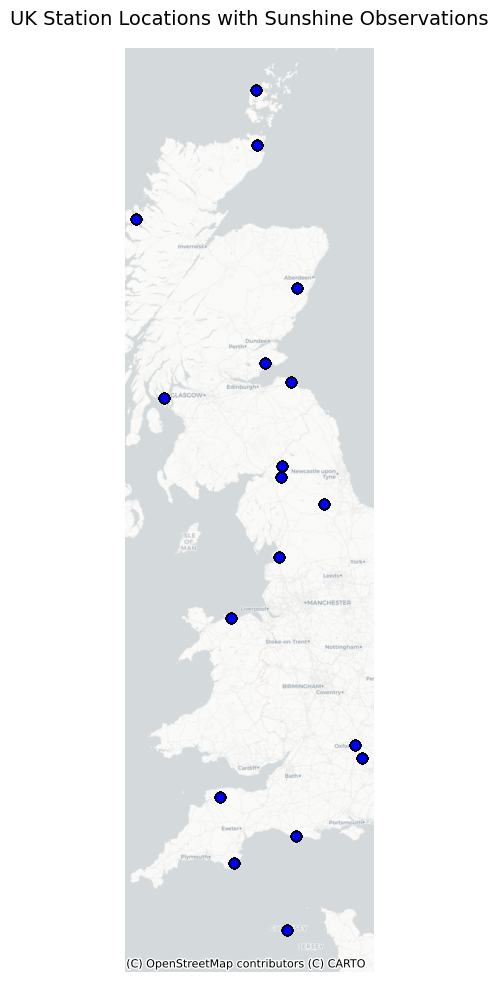

In [30]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

# Create GeoDataFrame from coordinates
geometry = [Point(xy) for xy in zip(sun_filtered['Longitude'], sun_filtered['Latitude'])]
gdf = gpd.GeoDataFrame(sun_filtered, geometry=geometry, crs="EPSG:4326")

# Reproject to Web Mercator for compatibility with contextily
gdf_web = gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(10, 12))
gdf_web.plot(ax=ax, markersize=50, color='blue', edgecolor='black', alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_title("UK Station Locations with Sunshine Observations", fontsize=14)
ax.set_axis_off()

plt.show()

### 1.4. CEDA wind data

#### 1.4.1 Loading in

In [31]:
# define the header based on provided column names
column_names = [
    "OB_END_TIME", "ID_TYPE", "ID", "OB_HOUR_COUNT", "MET_DOMAIN_NAME",
    "VERSION_NUM", "SRC_ID", "REC_ST_IND", "MEAN_WIND_DIR", "MEAN_WIND_SPEED",
    "MAX_GUST_DIR", "MAX_GUST_SPEED", "MAX_GUST_CTIME", "MEAN_WIND_DIR_Q",
    "MEAN_WIND_SPEED_Q", "MAX_GUST_DIR_Q", "MAX_GUST_SPEED_Q", "MAX_GUST_CTIME_Q",
    "METO_STMP_TIME", "MIDAS_STMP_ETIME", "MEAN_WIND_DIR_J", "MEAN_WIND_SPEED_J",
    "MAX_GUST_DIR_J", "MAX_GUST_SPEED_J"
]

# Read CSV and treat empty strings as NaN
df = pd.read_csv(
    "Data/midas_wind_202401-202412.txt",
    header=None,
    names=column_names,
    na_values=['', ' '],  # Treat empty strings and single spaces as NaN
    keep_default_na=True
)

# Check result
display(df.head())
print(df.isna().sum())  # Check number of NaNs per column

,OB_END_TIME,ID_TYPE,ID,OB_HOUR_COUNT,MET_DOMAIN_NAME,VERSION_NUM,SRC_ID,REC_ST_IND,MEAN_WIND_DIR,MEAN_WIND_SPEED,...,MEAN_WIND_SPEED_Q,MAX_GUST_DIR_Q,MAX_GUST_SPEED_Q,MAX_GUST_CTIME_Q,METO_STMP_TIME,MIDAS_STMP_ETIME,MEAN_WIND_DIR_J,MEAN_WIND_SPEED_J,MAX_GUST_DIR_J,MAX_GUST_SPEED_J
0,2024-01-01 00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,200.0,4.0,...,106.0,106.0,106.0,106.0,2024-01-01 00:03,0.0,NaN,NaN,NaN,NaN
1,2024-01-01 00:00,CLBN,240301,1,AWSHRLY,1,18907,1011,240.0,15.0,...,106.0,106.0,106.0,106.0,2024-01-01 00:03,0.0,NaN,NaN,NaN,NaN
2,2024-01-01 00:00,CLBN,247201,1,AWSHRLY,1,62283,1011,250.0,20.0,...,0.0,0.0,0.0,0.0,2024-01-01 00:03,0.0,NaN,NaN,NaN,NaN
3,2024-01-01 00:00,CLBN,421002,1,AWSHRLY,1,61974,1011,240.0,13.0,...,106.0,106.0,106.0,106.0,2024-01-01 00:03,0.0,NaN,NaN,NaN,NaN
4,2024-01-01 00:00,CLBN,455501,1,AWSHRLY,1,62047,1011,230.0,13.0,...,106.0,106.0,106.0,106.0,2024-01-01 00:03,0.0,NaN,NaN,NaN,NaN


OB_END_TIME                0
ID_TYPE                    0
ID                         0
OB_HOUR_COUNT              0
MET_DOMAIN_NAME            0
VERSION_NUM                0
SRC_ID                     0
REC_ST_IND                 0
MEAN_WIND_DIR          48472
MEAN_WIND_SPEED        45913
MAX_GUST_DIR           49228
MAX_GUST_SPEED          3048
MAX_GUST_CTIME         45471
MEAN_WIND_DIR_Q        48018
MEAN_WIND_SPEED_Q      45369
MAX_GUST_DIR_Q         48495
MAX_GUST_SPEED_Q        2500
MAX_GUST_CTIME_Q       44925
METO_STMP_TIME             0
MIDAS_STMP_ETIME           1
MEAN_WIND_DIR_J      1902520
MEAN_WIND_SPEED_J    1902520
MAX_GUST_DIR_J       1902520
MAX_GUST_SPEED_J     1902520
dtype: int64


#### 1.4.2. Wrangling

In [32]:
# sort by VERSION_NUM descending to prioritize 1 over 0
df_sorted = df.sort_values(by='VERSION_NUM', ascending=False)

# drop duplicates keeping the first (VERSION_NUM==1 if available)
wind_deduped = df_sorted.drop_duplicates(subset=['ID', 'OB_END_TIME'], keep='first')

# reset index
wind_deduped.reset_index(drop=True, inplace=True)

# preview result
display(wind_deduped.head())

,OB_END_TIME,ID_TYPE,ID,OB_HOUR_COUNT,MET_DOMAIN_NAME,VERSION_NUM,SRC_ID,REC_ST_IND,MEAN_WIND_DIR,MEAN_WIND_SPEED,...,MEAN_WIND_SPEED_Q,MAX_GUST_DIR_Q,MAX_GUST_SPEED_Q,MAX_GUST_CTIME_Q,METO_STMP_TIME,MIDAS_STMP_ETIME,MEAN_WIND_DIR_J,MEAN_WIND_SPEED_J,MAX_GUST_DIR_J,MAX_GUST_SPEED_J
0,2024-12-31 23:00,WMO,88897,1,SYNOP,1,1611,1011,NaN,NaN,...,NaN,NaN,1.0,NaN,2024-12-31 23:02,119.0,NaN,NaN,NaN,NaN
1,2024-01-01 00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,200.0,4.0,...,106.0,106.0,106.0,106.0,2024-01-01 00:03,0.0,NaN,NaN,NaN,NaN
2,2024-01-01 00:00,CLBN,240301,1,AWSHRLY,1,18907,1011,240.0,15.0,...,106.0,106.0,106.0,106.0,2024-01-01 00:03,0.0,NaN,NaN,NaN,NaN
3,2024-01-01 00:00,CLBN,247201,1,AWSHRLY,1,62283,1011,250.0,20.0,...,0.0,0.0,0.0,0.0,2024-01-01 00:03,0.0,NaN,NaN,NaN,NaN
4,2024-01-01 00:00,CLBN,421002,1,AWSHRLY,1,61974,1011,240.0,13.0,...,106.0,106.0,106.0,106.0,2024-01-01 00:03,0.0,NaN,NaN,NaN,NaN


In [33]:
# Filter for SRC_ID 62009 and sort by OB_END_TIME
obs_62009 = wind_deduped[wind_deduped['SRC_ID'] == 62009].copy()
obs_62009['OB_END_TIME'] = pd.to_datetime(obs_62009['OB_END_TIME'])
obs_62009 = obs_62009.sort_values('OB_END_TIME')
display(obs_62009)

,OB_END_TIME,ID_TYPE,ID,OB_HOUR_COUNT,MET_DOMAIN_NAME,VERSION_NUM,SRC_ID,REC_ST_IND,MEAN_WIND_DIR,MEAN_WIND_SPEED,...,MEAN_WIND_SPEED_Q,MAX_GUST_DIR_Q,MAX_GUST_SPEED_Q,MAX_GUST_CTIME_Q,METO_STMP_TIME,MIDAS_STMP_ETIME,MEAN_WIND_DIR_J,MEAN_WIND_SPEED_J,MAX_GUST_DIR_J,MAX_GUST_SPEED_J
1,2024-01-01 00:00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,200.0,4.0,...,106.0,106.0,106.0,106.0,2024-01-01 00:03,0.0,NaN,NaN,NaN,NaN
202,2024-01-01 01:00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,210.0,4.0,...,106.0,106.0,106.0,106.0,2024-01-01 01:03,0.0,NaN,NaN,NaN,NaN
395,2024-01-01 02:00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,220.0,3.0,...,106.0,106.0,106.0,106.0,2024-01-01 02:03,0.0,NaN,NaN,NaN,NaN
588,2024-01-01 03:00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,200.0,4.0,...,106.0,106.0,106.0,106.0,2024-01-01 03:03,0.0,NaN,NaN,NaN,NaN
780,2024-01-01 04:00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,210.0,5.0,...,106.0,106.0,106.0,106.0,2024-01-01 04:03,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151230,2024-12-31 19:00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,240.0,5.0,...,1.0,1.0,1.0,1.0,2024-12-31 19:02,0.0,NaN,NaN,NaN,NaN
116937,2024-12-31 20:00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,210.0,12.0,...,1.0,1.0,1.0,1.0,2024-12-31 20:02,0.0,NaN,NaN,NaN,NaN
88613,2024-12-31 21:00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,200.0,14.0,...,1.0,1.0,1.0,1.0,2024-12-31 21:02,0.0,NaN,NaN,NaN,NaN
58994,2024-12-31 22:00:00,CLBN,49001,1,AWSHRLY,1,62009,1011,250.0,11.0,...,1.0,1.0,1.0,1.0,2024-12-31 22:02,0.0,NaN,NaN,NaN,NaN


Calculate daily values:

In [34]:
wind_deduped = wind_deduped.copy()

# force datetime conversion and coerce errors
wind_deduped['OB_END_TIME'] = pd.to_datetime(wind_deduped['OB_END_TIME'], errors='coerce')

# drop rows where conversion failed
wind_deduped = wind_deduped.dropna(subset=['OB_END_TIME'])

# extract time and date
wind_deduped.loc[:, 'hour'] = wind_deduped['OB_END_TIME'].dt.hour
wind_deduped.loc[:, 'date'] = wind_deduped['OB_END_TIME'].dt.date

# Filter rows between 6am (inclusive) and 10pm (exclusive)
daytime = wind_deduped[(wind_deduped['hour'] >= 6) & (wind_deduped['hour'] < 22)]

# Group by SRC_ID and date
grouped = daytime.groupby(['SRC_ID', 'date'])

# Calculate mean of MEAN_WIND_SPEED and max of MAX_GUST_SPEED, skipping NaNs
daily_wind = (
    daytime
    .groupby(['SRC_ID', 'date'])
    .agg(
        mean_wind_speed_daytime=('MEAN_WIND_SPEED', 'mean'),
        max_gust_speed_daytime=('MAX_GUST_SPEED', 'max')
    )
    .reset_index()
)

In [35]:
display(daily_wind.head())

,SRC_ID,date,mean_wind_speed_daytime,max_gust_speed_daytime
0,3,2024-01-01,16.3750,35.0
1,3,2024-01-02,33.3750,63.0
2,3,2024-01-03,26.6250,49.0
3,3,2024-01-04,26.0000,45.0
4,3,2024-01-05,25.6875,44.0


In [36]:
print(len(daily_wind['SRC_ID'].unique()))

226


In [37]:
print(len(daily_wind['date'].unique()))

366


Get matching dates:

In [38]:
date_counts = daily_wind.groupby('SRC_ID')['date'].nunique()

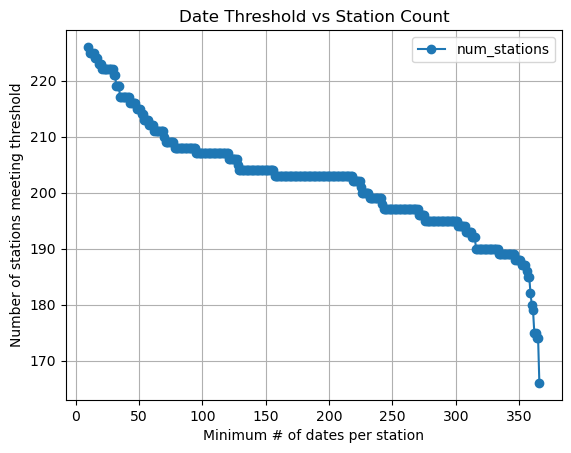

In [39]:
thresholds = range(10, date_counts.max() + 1)
results = [(t, (date_counts >= t).sum()) for t in thresholds]

# convert to DataFrame
threshold_df = pd.DataFrame(results, columns=['min_dates', 'num_stations'])

# plot the tradeoff
threshold_df.plot(x='min_dates', y='num_stations', title='Date Threshold vs Station Count', marker='o')
plt.xlabel("Minimum # of dates per station")
plt.ylabel("Number of stations meeting threshold")
plt.grid(True)
plt.show()

Select 330 days:

In [40]:
# count how many times each ID appears
id_counts = daily_wind['SRC_ID'].value_counts()

# get IDs with at least 330 occurrences
valid_ids = id_counts[id_counts >= 330].index

# filter the DataFrame
wind_filtered = daily_wind[daily_wind['SRC_ID'].isin(valid_ids)]

# reset index
wind_filtered.reset_index(drop=True, inplace=True)

# preview result
display(wind_filtered.head())

,SRC_ID,date,mean_wind_speed_daytime,max_gust_speed_daytime
0,3,2024-01-01,16.3750,35.0
1,3,2024-01-02,33.3750,63.0
2,3,2024-01-03,26.6250,49.0
3,3,2024-01-04,26.0000,45.0
4,3,2024-01-05,25.6875,44.0


In [41]:
wind_filtered = wind_filtered.copy()

# convert date to datetime
wind_filtered['date'] = pd.to_datetime(wind_filtered['date'], errors='coerce')

# convert datetime to just the date part for grouping
wind_filtered['date'] = wind_filtered['date'].dt.date

# count how many unique SRC_IDs you have
num_stations = wind_filtered['SRC_ID'].nunique()

# count how many unique SRC_IDs reported data on each date
station_counts_per_day = wind_filtered.groupby('date')['SRC_ID'].nunique()

# filter to dates where all SRC_IDs are present
full_coverage_dates = station_counts_per_day[station_counts_per_day == num_stations].index

# get only rows from those dates
wind_full_coverage = wind_filtered[wind_filtered['date'].isin(full_coverage_dates)]

display(wind_full_coverage.head())

,SRC_ID,date,mean_wind_speed_daytime,max_gust_speed_daytime
14,3,2024-01-15,21.666667,46.0
15,3,2024-01-16,13.642857,33.0
16,3,2024-01-17,15.812500,36.0
17,3,2024-01-18,19.000000,47.0
18,3,2024-01-19,12.875000,36.0


In [42]:
print(wind_full_coverage['SRC_ID'].unique())
len(wind_full_coverage['SRC_ID'].unique())

[    3     9    12    23    32    44    48    52    54    67    79   103
   105   113   117   132   137   145   150   161   177   212   235   268
   315   358   370   373   384   386   393   395   405   409   421   440
   456   461   498   513   534   554   556   583   595   605   613   643
   657   669   671   692   708   709   719   723   726   743   744   775
   779   795   811   842   847   862   876   888   889   908   918   982
   987  1007  1023  1033  1039  1046  1055  1060  1074  1076  1078  1083
  1085  1090  1125  1137  1144  1145  1161  1171  1180  1190  1198  1209
  1215  1226  1285  1302  1319  1336  1346  1352  1367  1383  1386  1393
  1395  1415  1435  1448  1450  1467  1488  1504  1529  1530  1534  1543
  1575  1585  1588  1605  1609  6182  6313  9861 16589 16596 16611 16725
 17224 17309 17314 17344 18903 18907 18915 18974 19187 19188 19206 19260
 23417 24102 24125 24996 25069 25727 30270 30523 30620 30690 56486 56810
 56958 56962 56963 57063 57192 57193 57199 57231 57

190

In [43]:
# extract unique SRC_IDs from wind_full_coverage and write to CSV
unique_src_ids = wind_full_coverage['SRC_ID'].unique()
pd.DataFrame({'SRC_ID': unique_src_ids}).to_csv('unique_wind_station_ids.csv', index=False)

#### 1.4.3. Interpolation

### 1.5. Joining CEDA to retail